# 6章：要約

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="2.24.0", download_mode="force_redownload")
dataset["train"].column_names

In [12]:
#sample_text = dataset["train"][1]["article"][:2000]
sample_text =   "We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future. \
Once you start working in the community, you are not only required to solve the problem of your clients or others, \
but also to spot or suggest a potential issue which even the client doesn’t notice. When you write a bachelor/master thesis, \
you also need to explore the unsolved problems by yourself, address them by all possible means to search for a solution, and give your findings back to the society. \
Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/works, and to appeal to others, \
which would be useful anywhere in the society. There is always someone who has been conducting a related study in the world. \
Whenever you advance your research, you will face challenges from the world. For this reason, even when you write a bachelor/master thesis, \
you should set the research topic bearing in mind the need to present the findings of your research in international conferences or journals. \
The laboratory has diverse people with various hobbies, skills, and thoughts; we respect the individuality of each member, learn from others, and have fun together. \
We hope that your experiences in the laboratory will be invaluable for the rest of your lives."
summaries = {}
sample_text

'We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future. Once you start working in the community, you are not only required to solve the problem of your clients or others, but also to spot or suggest a potential issue which even the client doesn’t notice. When you write a bachelor/master thesis, you also need to explore the unsolved problems by yourself, address them by all possible means to search for a solution, and give your findings back to the society. Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/works, and to appeal to others, which would be useful anywhere in the society. There is always someone who has been conducting a related study in the world. Whenever you advance your research, you will face challenges from the world. For this reason, even when you write a bachelor/master thesis, you should set th

In [13]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ace14385kw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n" #GPT-2で要約をする際の接尾辞
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [15]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [16]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [17]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [18]:
for model_name in summaries:
    print(model_name)
    print(summaries[model_name])
    print("")

gpt2
Experimentation may make you smarter, but it doesn't make you better
The scientific method gives the scientific community the opportunity to do practical work.
There will be many people working in the community, both inside and outside of the laboratory.
If you don't have experience or skills in research, try to read a research lab manual first.
Work in the laboratory will require to get used to working with people and making practical solutions as they are needed.

t5
we hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future .
the laboratory has diverse people with various hobbies, skills, and thoughts .

bart
We hope the students joined the laboratory to acquire skills through research activities and make a confident start as a member of society in the future.
Through your research, you can acquire abilities to establish your specialty as if building your castle, to complete theories/w

### 評価指標

In [19]:
from datasets import load_metric
import pandas as pd
import numpy as np

bleu_metric = load_metric("sacrebleu")
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


### 要約モデルの学習

In [5]:
from datasets import load_dataset

dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
split_lengths

Reusing dataset samsum (/home/ace14385kw/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

[14732, 819, 818]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


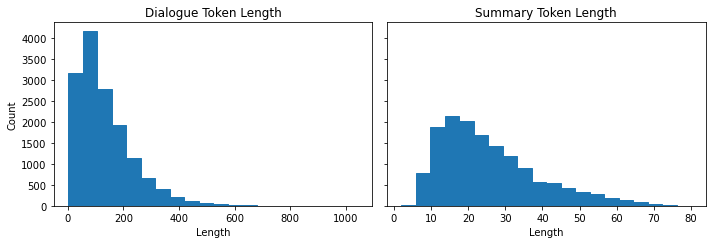

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt

model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [9]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)

    # エンコーダーの入力とデコーダーの入力のトークン化の区別
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    
    return {"input_ids": input_encodings["input_ids"], "attention_mask": input_encodings["attention_mask"], "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Loading cached processed dataset at /home/ace14385kw/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-ce4c842d05751909.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/ace14385kw/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-be33cca5993aead3.arrow


In [10]:
# DataCollatorの定義
    # バッチがモデルに渡される直前にTrainerで呼び出される
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# TrainingArguments・Trainerの定義
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsum", num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy="steps", eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

trainer = Trainer(model=model, args=training_args,
    tokenizer=tokenizer, data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"])

In [13]:
# 評価の関数
from tqdm import tqdm
import torch
from datasets import load_metric

rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="article", column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                        attention_mask=inputs["attention_mask"].to(device),
                        length_penalty=0.8, num_beams=8, max_lengths=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score

In [ ]:
# 学習と評価
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary"
)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
trainer.push_to_hub(commit_message="『機械学習エンジニアのためのTransformers』6章")

In [17]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

pipe(sample_text, **gen_kwargs)

loading configuration file https://huggingface.co/transformersbook/pegasus-samsum/resolve/main/config.json from cache at /home/ace14385kw/.cache/huggingface/transformers/9a5cb9a0935404e213ea4d6660ec998c8903f45b15985faea3723d41052e6c51.b9fd170a6ee00fb97f4ced2d5b71419456e17db01c70b8af45819cba68d4f096
Model config PegasusConfig {
  "_name_or_path": "google/pegasus-cnn_dailymail",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embe

[{'summary_text': "Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty."}]